# Tutorial 3: El filtro de Kalman

**Week 3, Day 2: Dinámica Oculta**

**por Neuromatch Academy**

**Creadores de Contenido:** Itzel Olivos Castillo and Xaq Pitkow

**Editores de producción:** Gagana B, Spiros Chavlis

<br>

**Referencias útiles:**
- Roweis, Ghahramani (1998): A unifying review of linear Gaussian Models
- Bishop (2006): Pattern Recognition and Machine Learning

---
# Objetivos del tutorial

En tutoriales anteriores utilizamos modelos ocultos de Markov (HMM) para inferir estados latentes *discretos* a partir de una secuencia de mediciones. En este tutorial, aprenderemos cómo inferir una variable latente *continua* usando el filtro de Kalman, que es una versión de un HMM.

<br>

En este tutorial, podrás:
* Repasar sistemas dinámicos lineales.
* Conocer el filtro de Kalman en una dimensión
* Manipular parámetros de un proceso para ver cómo se comporta el filtro de Kalman
* Pensar en algunas propiedades fundamentales del filtro de Kalman.

Puedes imaginar que este proceso de inferencia ocurre cuando Mission Control intenta localizar y rastrear a Astrogato. Pero también se puede imaginar que el cerebro utiliza un modelo oculto de Markov análogo para rastrear objetos en el mundo o estimar las consecuencias de sus propias acciones. Y se podría utilizar esta técnica para estimar la actividad cerebral a partir de mediciones ruidosas, para comprender o para construir una interfaz cerebro-computadora.

---
# Configuración

##  Instalar e importar gadget de comentarios


In [2]:
# Imports
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import transforms
from collections import namedtuple
from scipy.stats import norm

##  Configuración de figuras


In [3]:
# @title Configuración de figuras
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
from ipywidgets import interactive, interact, HBox, Layout,VBox
from IPython.display import HTML
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

##  Funciones de graficado


In [4]:
# @title Funciones de graficado

def visualize_Astrocat(s, T):
  plt.plot(s, color='limegreen', lw=2)
  plt.plot([T], [s[-1]], marker='o', markersize=8, color='limegreen')
  plt.xlabel('Time t')
  plt.ylabel('s(t)')
  plt.show()


def plot_measurement(s, m, T):
  plt.plot(s, color='limegreen', lw=2, label='true position')
  plt.plot([T], [s[-1]], marker='o', markersize=8, color='limegreen')
  plt.plot(m, '.', color='crimson', lw=2, label='measurement')
  plt.xlabel('Time t')
  plt.ylabel('s(t)')
  plt.legend()
  plt.show()


def plot_function(u=1,v=2,w=3,x=4,y=5,z=6):
  time = np.arange(0, 1, 0.01)
  df = pd.DataFrame({"y1":np.sin(time*u*2*np.pi),
                     "y2":np.sin(time*v*2*np.pi),
                     "y3":np.sin(time*w*2*np.pi),
                     "y4":np.sin(time*x*2*np.pi),
                     "y5":np.sin(time*y*2*np.pi),
                     "y6":np.sin(time*z*2*np.pi)})
  df.plot()

##  Funciones de ayuda


In [5]:
# @title Funciones de ayuda
gaussian = namedtuple('Gaussian', ['mean', 'cov'])

def filter(D, process_noise, measurement_noise, posterior, m):
  todays_prior = gaussian(D * posterior.mean, D**2 * posterior.cov + process_noise)
  likelihood = gaussian(m, measurement_noise)

  info_prior = 1/todays_prior.cov
  info_likelihood = 1/likelihood.cov
  info_posterior = info_prior + info_likelihood

  prior_weight = info_prior / info_posterior
  likelihood_weight = info_likelihood / info_posterior
  posterior_mean = prior_weight * todays_prior.mean  +  likelihood_weight * likelihood.mean

  posterior_cov = 1/info_posterior
  todays_posterior = gaussian(posterior_mean, posterior_cov)
  """
  prior = gaussian(belief.mean, belief.cov)

  predicted_estimate = D * belief.mean
  predicted_covariance = D**2 * belief.cov + process_noise

  likelihood = gaussian(m, measurement_noise)
  innovation_estimate = m - predicted_estimate
  innovation_covariance = predicted_covariance + measurement_noise

  K = predicted_covariance / innovation_covariance  # Kalman gain, i.e. the weight given to the difference between the measurement and predicted measurement
  updated_mean = predicted_estimate + K * innovation_estimate
  updated_cov = (1 - K) * predicted_covariance
  todays_posterior = gaussian(updated_mean, updated_cov)
  """
  return todays_prior, likelihood, todays_posterior


def paintMyFilter(D, initial_guess, process_noise, measurement_noise, s, m, s_, cov_):
  # Compare solution with filter function

  filter_s_ = np.zeros(T)  # estimate (posterior mean)
  filter_cov_ = np.zeros(T)  # uncertainty (posterior covariance)

  posterior = initial_guess
  filter_s_[0] = posterior.mean
  filter_cov_[0] = posterior.cov

  process_noise_std = np.sqrt(process_noise)
  measurement_noise_std = np.sqrt(measurement_noise)

  for i in range(1, T):
    prior, likelihood, posterior = filter(D, process_noise, measurement_noise, posterior, m[i])
    filter_s_[i] =  posterior.mean
    filter_cov_[i] = posterior.cov

  smin = min(min(m),min(s-2*np.sqrt(cov_[-1])), min(s_-2*np.sqrt(cov_[-1])))
  smax = max(max(m),max(s+2*np.sqrt(cov_[-1])), max(s_+2*np.sqrt(cov_[-1])))
  pscale = 0.2  # scaling factor for displaying pdfs

  fig = plt.figure(figsize=[15, 10])
  ax = plt.subplot(2, 1, 1)
  ax.set_xlabel('time')
  ax.set_ylabel('state')
  ax.set_xlim([0, T+(T*pscale)])
  ax.set_ylim([smin, smax])

  ax.plot(t, s, color='limegreen', lw=2, label="Astrocat's trajectory")
  ax.plot([t[-1]], [s[-1]], marker='o', markersize=8, color='limegreen')

  ax.plot(t, m, '.', color='crimson', lw=2, label='measurements')
  ax.plot([t[-1]], [m[-1]], marker='o', markersize=8, color='crimson')

  ax.plot(t, filter_s_, color='black', lw=2, label='correct estimated trajectory')
  ax.plot([t[-1]], [filter_s_[-1]], marker='o', markersize=8, color='black')

  res = '! :)' if np.mean((s_ - filter_s_)**2) < 0.1 else ' :('
  ax.plot(t, s_, '--', color='lightgray', lw=2, label='your estimated trajectory' + res)
  ax.plot([t[-1]], [s_[-1]], marker='o', markersize=8, color='lightgray')

  plt.legend()
  plt.show()

---
# Sección 1: Dinámica de Astrogato

## Section 1.1: Simulando los movimientos de Astrogato

### Ejercicio de programación 1.1: Simulando los movimientos de Astrogato

Primero, simulará cómo se mueve Astrogato basándose en dinámica lineal estocástica.

El sistema dinámico lineal $s_t = Ds_{t-1} + w_{t-1}$ determina la posición de Astrogato $s_t$. $D$ es un escalar que modela cómo le gustaría a Astrogato cambiar su posición con el tiempo, y $w_t \sim \mathcal{N}(0, \sigma_p^2)$ es un ruido blanco gaussiano causado por actuadores poco confiables en la unidad de propulsión de Astrogato. .

Complete el código siguiente para simular posibles trayectorias.

Primero, ejecute la siguiente celda para habilitar los parámetros predeterminados que usaremos en este tutorial.

In [6]:
# Fixed params
np.random.seed(0)

T_max = 200
D = 1
tau_min = 1
tau_max = 50
process_noise_min = 0.1
process_noise_max = 10
measurement_noise_min = 0.1
measurement_noise_max = 10

unit_process_noise = np.random.randn(T_max)  # compute all N(0, 1) in advance to speed up time slider
unit_measurement_noise = np.random.randn(T_max)  # compute all N(0, 1) in advance to speed up time slider

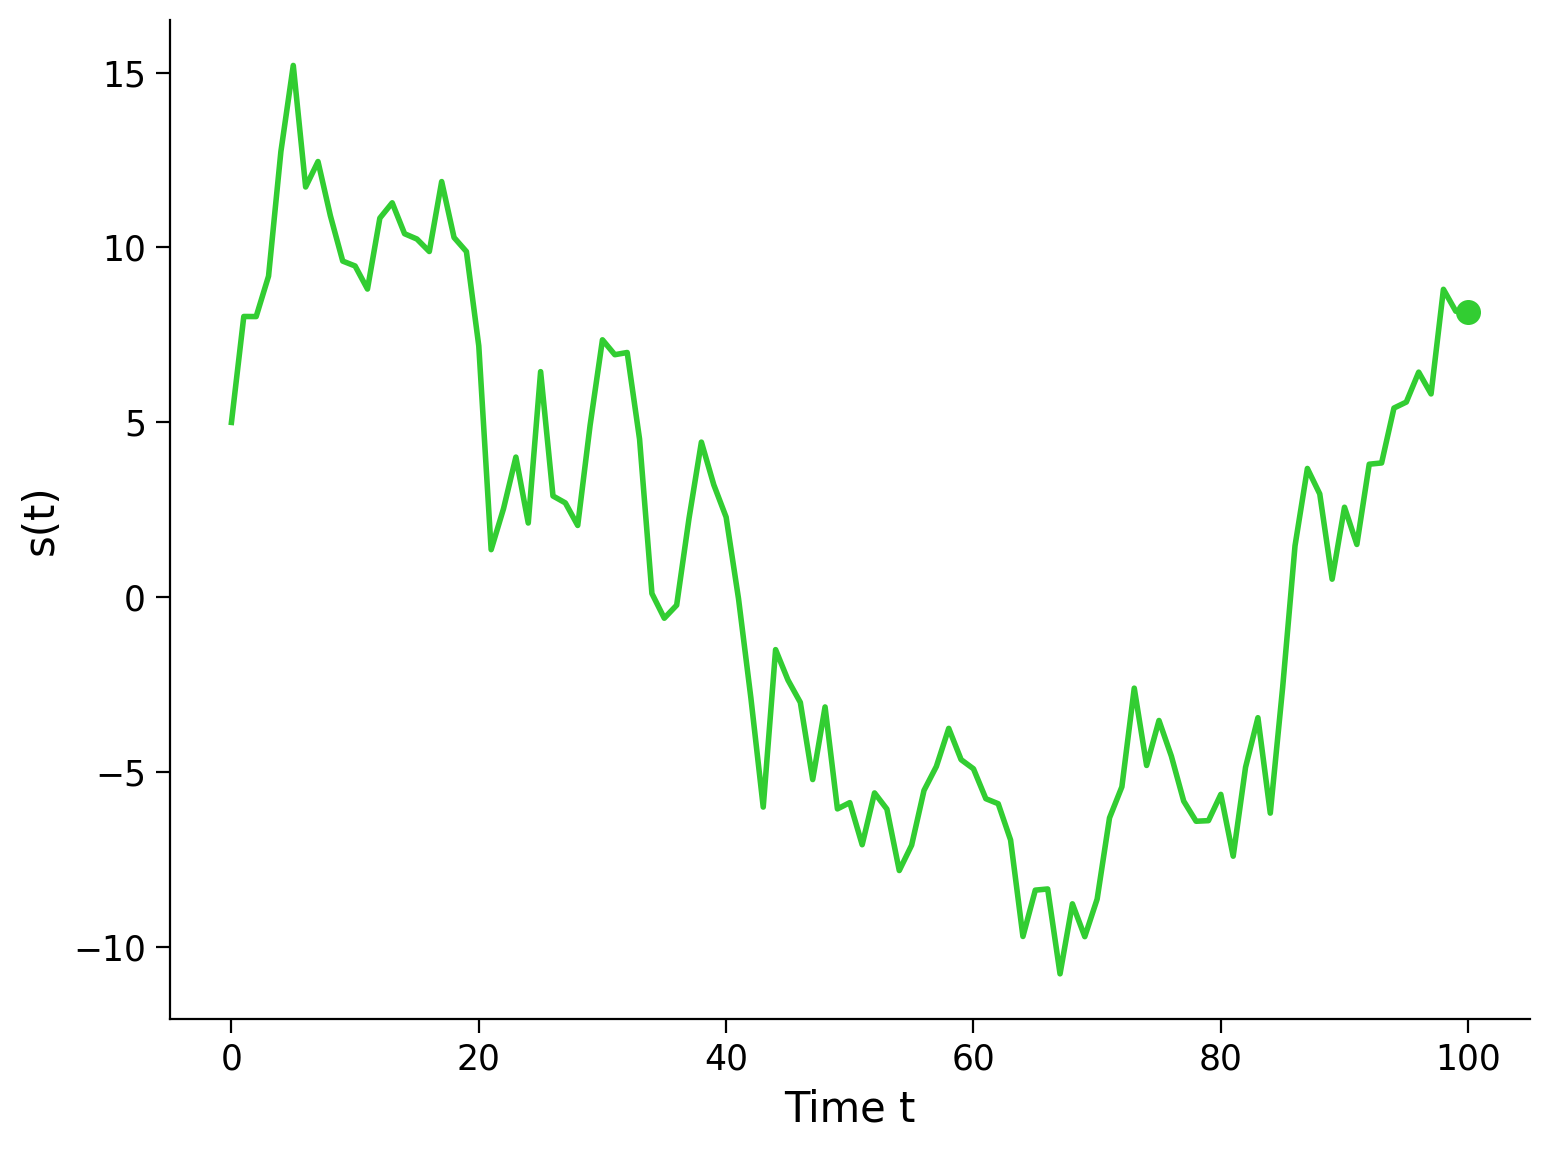

In [7]:

def simulate(D, s0, sigma_p, T):
  """ Compute the response of the linear dynamical system.

  Args:
    D (scalar): dynamics multiplier
    s0 (scalar): initial position
    sigma_p (scalar): amount of noise in the system (standard deviation)
    T (scalar): total duration of the simulation

  Returns:
    ndarray: `s`: astrocat's trajectory up to time T
  """

  # Initialize variables
  s = np.zeros(T+1)
  s[0] = s0

  # Compute the position at time t given the position at time t-1 for all t
  # Consider that np.random.normal(mu, sigma) generates a random sample from
  # a gaussian with mean = mu and standard deviation = sigma

  for t in range(1, len(s)):

    # Update position
    s[t] = D*s[t-1] + np.random.normal(0, sigma_p)

  return s


# Set random seed
np.random.seed(0)

# Set parameters
D = 0.9  # parameter in s(t)
T = 100  # total time duration
s0 = 5.  # initial condition of s at time 0
sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit

# Simulate Astrocat
s = simulate(D, s0, sigma_p, T)

# Visualize
# with plt.xkcd():
visualize_Astrocat(s, T)

### Demo Interactivo 1.1: Jugando con el movimiento de Astrogato

Usaremos la función que acaba de implementar en una demostración, donde puede cambiar el valor de $D$ y ver qué sucede.


1. ¿Qué sucede cuando D es grande (>1)? ¿Por qué?
2. ¿Qué sucede cuando D es un número negativo grande (<-1)? ¿Por qué?
3. ¿Qué pasa cuando D es cero?

In [8]:
# @markdown Ejecute esta celda para habilitar la demo

@widgets.interact(D=widgets.FloatSlider(value=-.5, min=-2, max=2, step=0.1))
def plot(D=D):
  # Set parameters
  T = 100  # total time duration
  s0 = 5.  # initial condition of s at time 0
  sigma_p = 1  # amount of noise in the actuators of astrocat's propulsion unit

  # Simulate Astrocat
  s = simulate(D, s0, sigma_p, T)

  # Visualize
  visualize_Astrocat(s, T)

interactive(children=(FloatSlider(value=-0.5, description='D', max=2.0, min=-2.0), Output()), _dom_classes=('w…

## Section 1.2: Midiendo los movimientos de Astrogato

### Ejercicio de programación 1.2.1: Leeyendo mediciones del collar de Astrogato



Estimaremos la posición real de Astrogato utilizando mediciones de un sensor ruidoso colocado en su collar.

Complete la siguiente función para leer las mediciones del collar de Astrogato. Estas mediciones son correctas excepto por el ruido gaussiano aditivo cuya desviación estándar viene dada por el argumento de entrada `sigma_measurements`.

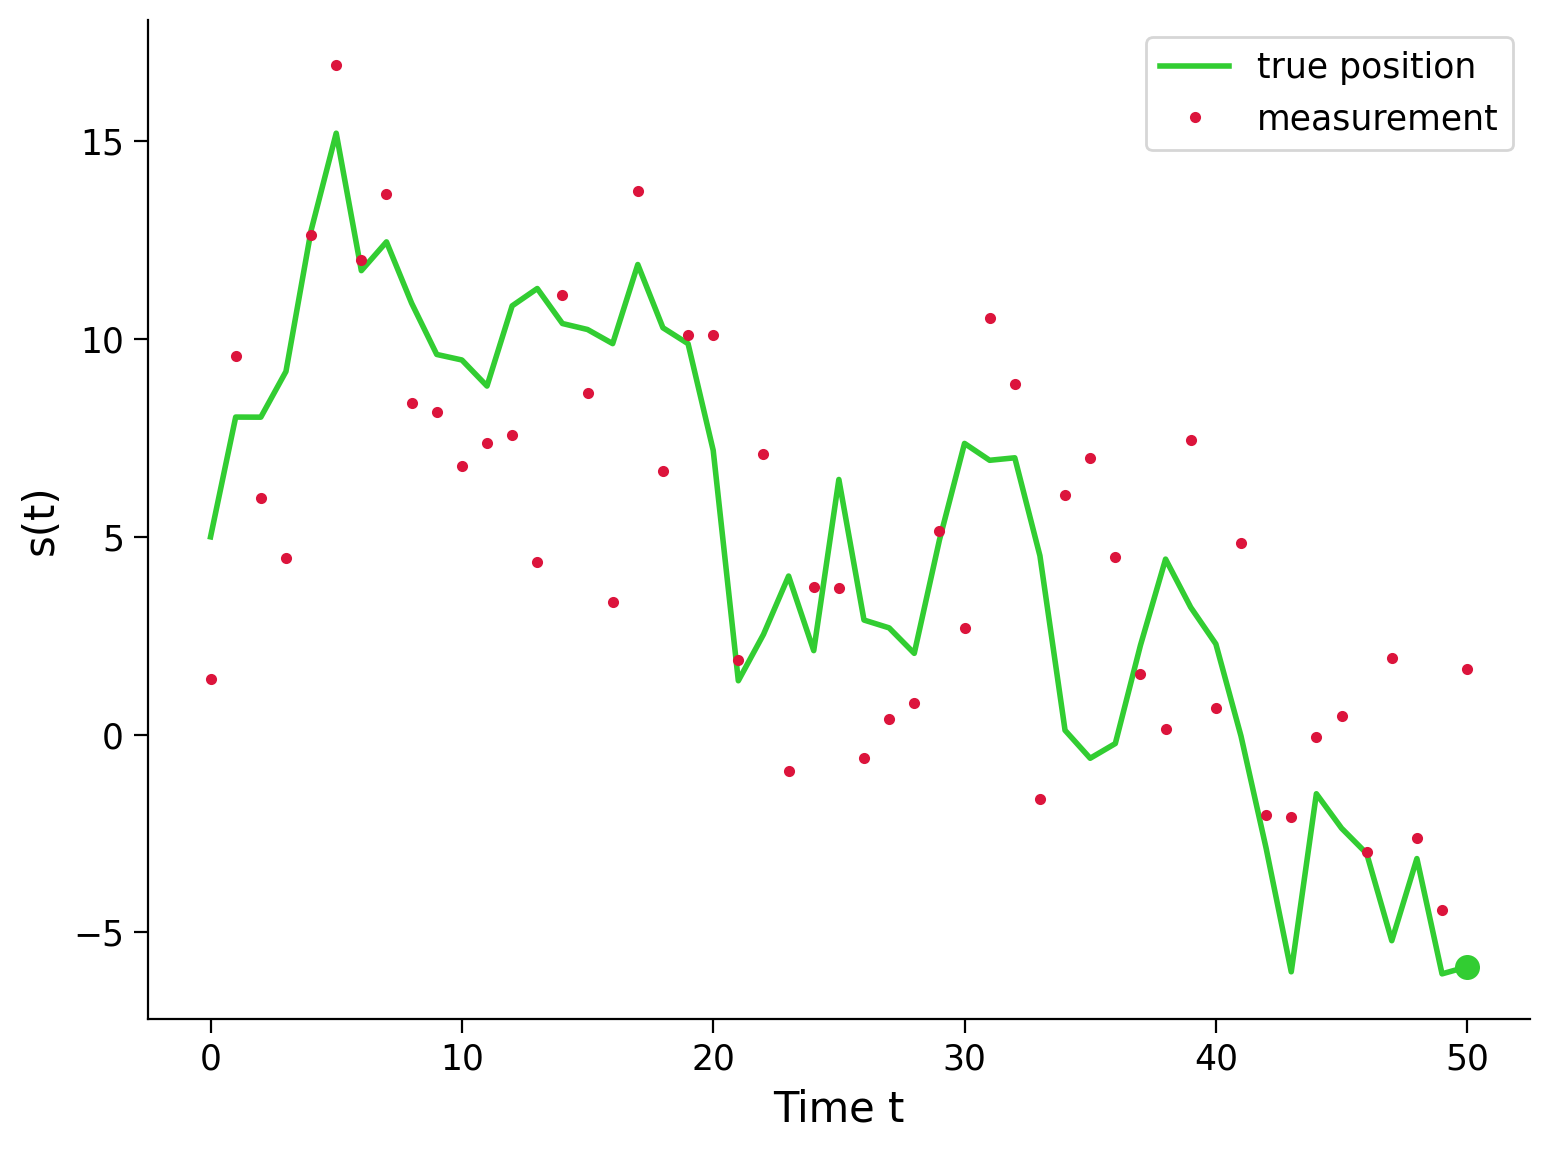

In [9]:
def read_collar(s, sigma_measurements):
  """ Compute the measurements of the noisy sensor attached to astrocat's collar

  Args:
    s (ndarray): astrocat's true position over time
    sigma_measurements (scalar): amount of noise in the sensor (standard deviation)

  Returns:
    ndarray: `m`: astrocat's position over time according to the sensor
  """

  # Initialize variables
  m = np.zeros(len(s))

  # For all time t, add white Gaussian noise with magnitude sigma_measurements
  # Consider that np.random.normal(mu, sigma) generates a random sample from
  # a gaussian with mean = mu and standard deviation = sigma

  for t in range(len(s)):

    # Read measurement
    m[t] = s[t] + np.random.normal(0, sigma_measurements)

  return m


# Set parameters
np.random.seed(0)
D = 0.9    # parameter in s(t)
T = 50      # total time duration
s0 = 5.     # initial condition of s at time 0
sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit
sigma_measurements = 4 # amount of noise in astrocat's collar

# Simulate Astrocat
s = simulate(D, s0, sigma_p, T)

# Take measurement from collar
m = read_collar(s, sigma_measurements)

# Visualize
plot_measurement(s, m, T)

### Ejercicio de programación 1.2.2: Comparando estados verdaderos con estados medidos



Haz un diagrama de dispersión para ver qué tan malas son las mediciones del collar de Astrogato. Este ejercicio mostrará por qué utilizar únicamente las medidas para rastrear a Astrogato puede ser catastrófico.

¡Un filtro Kalman resolverá este problema!

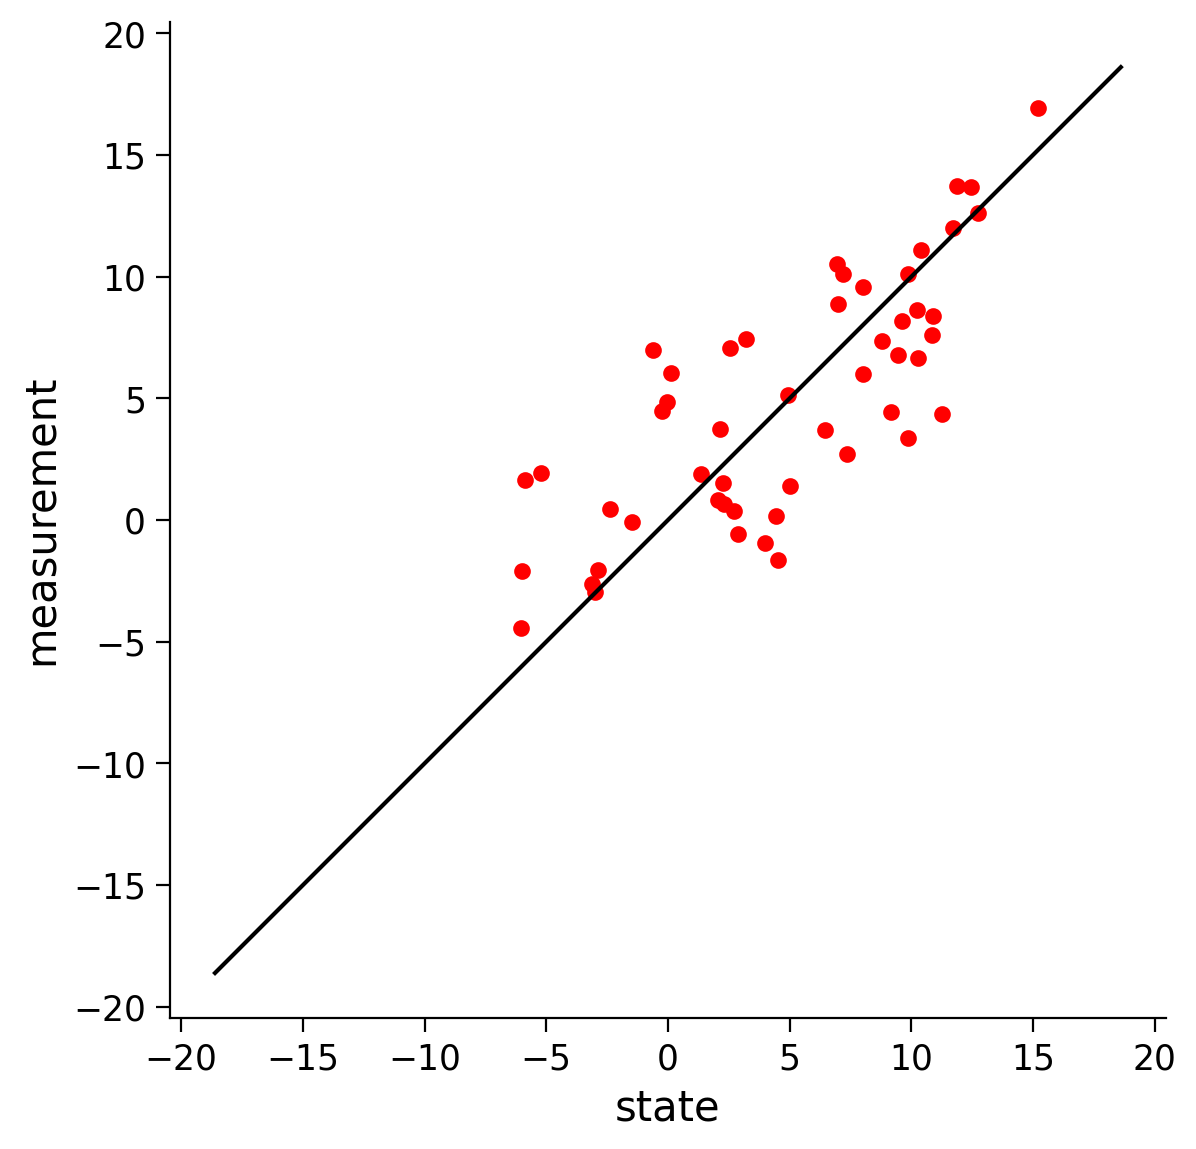

In [10]:
def compare(s, m):
  """ Compute a scatter plot

  Args:
    s (ndarray): astrocat's true position over time
    m (ndarray): astrocat's measured position over time according to the sensor

  """
  fig = plt.figure()
  ax = fig.add_subplot(111)
  sbounds = 1.1*max(max(np.abs(s)), max(np.abs(m)))
  ax.plot([-sbounds, sbounds], [-sbounds, sbounds], 'k')    # plot line of equality
  ax.set_xlabel('state')
  ax.set_ylabel('measurement')
  ax.set_aspect('equal')

  # Complete a scatter plot: true state versus measurements
  plt.scatter(s, m, marker='.', color='red', s=100)
  plt.show()


# Set parameters
np.random.seed(0)
D = 0.9  # parameter in s(t)
T = 50  # total time duration
s0 = 5.  # initial condition of s at time 0
sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit
sigma_measurements = 4 # amount of noise in astrocat's collar

# Simulate Astrocat
s = simulate(D, s0, sigma_p, T)

# Take measurement from collar
m = read_collar(s, sigma_measurements)

# Visualize true vs measured states
compare(s, m)

---
# Sección 2: El filtro Kalman



## Sección 2.1: Usando el filtro de Kalman


### Demo Interactivo 2.1: El filtro Kalman en acción

A continuación te proporcionamos una visualización interactiva para entender cómo funciona el filtro de Kalman. Juegue con los controles deslizantes para intuir cómo los diferentes factores afectan las inferencias del filtro de Kalman. Usted mismo codificará el filtro de Kalman en el siguiente ejercicio.

Los controles deslizantes:
* tiempo actual: el filtro Kalman sintetiza las mediciones hasta ese momento.
* constante de tiempo dinámica $\tau$: esto determina el valor de la dinámica, $D=\exp^{-\Delta t/\tau}$ donde $\Delta t$ es el paso de tiempo discreto (aquí 1).
* ruido de proceso: cantidad de ruido en los actuadores de la unidad de propulsión de Astrogato
* ruido de observación: los niveles de ruido de nuestras mediciones (cuando leemos el collar)

Algunas preguntas a considerar:
- ¿Qué afecta la previsibilidad de Astrogato?
- ¿Cómo cambia la confianza con el tiempo?
- ¿Qué afecta el peso relativo de la nueva medida?
- ¿Cómo se relaciona el error con la varianza posterior?

Ejecute esta celda para habilitar el widget. La actualización tarda unos segundos, así que tenga paciencia.

In [11]:
# @markdown Ejecute esta celda para habilitar el widget. La actualización tarda unos segundos, así que tenga paciencia.
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(T=widgets.IntSlider(T_max/4, description="current time",
                                      min=1, max=T_max-1),
                  tau=widgets.FloatSlider(tau_max/2,
                                          description='dynamics time constant',
                                          min=tau_min, max=tau_max),
                  process_noise=widgets.FloatSlider(2,
                                                    description="process noise",
                                                    min=process_noise_min,
                                                    max=process_noise_max),
                  measurement_noise=widgets.FloatSlider(3,
                                                        description="observation noise",
                                                        min=measurement_noise_min,
                                                        max=measurement_noise_max),
                  flag_s = widgets.Checkbox(value=True,
                                            description='state',
                                            disabled=True, indent=False),
                  flag_m = widgets.Checkbox(value=False,
                                            description='measurement',
                                            disabled=False, indent=False),
                  flag_s_ = widgets.Checkbox(value=False,
                                             description='estimate',
                                             disabled=False, indent=False),
                  flag_err_ = widgets.Checkbox(value=False,
                                               description='estimator confidence intervals',
                                               disabled=False, indent=False))


def stochastic_system(T, tau, process_noise, measurement_noise, flag_m, flag_s_, flag_err_):
  t = np.arange(0, T_max, 1)  # timeline
  s = np.zeros(T_max)  # states
  D = np.exp(-1/tau)  # dynamics multiplier (matrix if s is vector)
  process_noise_cov = process_noise**2
  measurement_noise_cov = measurement_noise**2

  prior_mean = 0
  prior_cov = process_noise_cov/(1-D**2)

  s[0] = np.sqrt(prior_cov) * unit_process_noise[0]   # Sample initial condition from equilibrium distribution

  m = np.zeros(T_max)  # measurement
  s_ = np.zeros(T_max)  # estimate (posterior mean)
  cov_ = np.zeros(T_max)  # uncertainty (posterior covariance)

  s_[0] = prior_mean
  cov_[0] = prior_cov
  posterior = gaussian(prior_mean, prior_cov)

  captured_prior = None
  captured_likelihood = None
  captured_posterior = None

  onfilter = True
  for i in range(1, T_max):
    s[i] = D * s[i-1] + process_noise * unit_process_noise[i-1]

    if onfilter:
      m[i] = s[i] + measurement_noise * unit_measurement_noise[i]

      prior, likelihood, posterior = filter(D, process_noise_cov, measurement_noise_cov, posterior, m[i])

      s_[i] =  posterior.mean
      cov_[i] = posterior.cov

    if i == T:
      onfilter = False
      captured_prior = prior
      captured_likelihood = likelihood
      captured_posterior = posterior

  smin = min(min(m),min(s-2*np.sqrt(cov_[-1])),min(s_-2*np.sqrt(cov_[-1])))
  smax = max(max(m),max(s+2*np.sqrt(cov_[-1])),max(s_+2*np.sqrt(cov_[-1])))
  pscale = 0.2  # scaling factor for displaying pdfs

  fig = plt.figure(figsize=[15, 10])
  ax = plt.subplot(2, 1, 1)
  ax.set_xlabel('time')
  ax.set_ylabel('state')
  ax.set_xlim([0, T_max+(T_max*pscale)])
  ax.set_ylim([smin, smax])

  show_pdf = [False, False]
  ax.plot(t[:T+1], s[:T+1], color='limegreen', lw=2)
  ax.plot(t[T:], s[T:], color='limegreen', lw=2, alpha=0.3)
  ax.plot([t[T:T+1]], [s[T:T+1]], marker='o', markersize=8, color='limegreen')

  if flag_m:
    ax.plot(t[:T+1], m[:T+1], '.', color='crimson', lw=2)
    ax.plot([t[T:T+1]], [m[T:T+1]], marker='o', markersize=8, color='crimson')

    domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
    pdf_likelihood = norm.pdf(domain, captured_likelihood.mean, np.sqrt(captured_likelihood.cov))
    ax.fill_betweenx(domain, T + pdf_likelihood*(T_max*pscale), T, color='crimson', alpha=0.5, label='likelihood', edgecolor="crimson", linewidth=0)
    ax.plot(T + pdf_likelihood*(T_max*pscale), domain, color='crimson', linewidth=2.0)

    ax.legend(ncol=3, loc='upper left')
    show_pdf[0] = True

  if flag_s_:
    ax.plot(t[:T+1], s_[:T+1], color='black', lw=2)
    ax.plot([t[T:T+1]], [s_[T:T+1]], marker='o', markersize=8, color='black')
    show_pdf[1] = True

  if flag_err_:
    ax.fill_between(t[:T+1], s_[:T+1] + 2 * np.sqrt(cov_)[:T+1], s_[:T+1] - 2 * np.sqrt(cov_)[:T+1], color='black', alpha=0.3)
    show_pdf[1] = True

  if show_pdf[1]:
    domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
    pdf_post = norm.pdf(domain, captured_posterior.mean, np.sqrt(captured_posterior.cov))
    ax.fill_betweenx(domain, T + pdf_post*(T_max*pscale), T, color='black', alpha=0.5, label='posterior', edgecolor="black", linewidth=0)
    ax.plot(T + pdf_post*(T_max*pscale), domain, color='black', linewidth=2.0)
    ax.legend(ncol=3, loc='upper left')

  if show_pdf[0] and show_pdf[1]:
    domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
    pdf_prior = norm.pdf(domain, captured_prior.mean, np.sqrt(captured_prior.cov))
    ax.fill_betweenx(domain, T + pdf_prior*(T_max*pscale), T, color='dodgerblue', alpha=0.5, label='prior', edgecolor="dodgerblue", linewidth=0)
    ax.plot(T + pdf_prior*(T_max*pscale), domain, color='dodgerblue', linewidth=2.0)
    ax.legend(ncol=3, loc='upper left')

  plt.show()

interactive(children=(IntSlider(value=50, description='current time', max=199, min=1), FloatSlider(value=25.0,…

### Ejercicio de programación 2.1: Implemente su propio filtro Kalman



Como vio en el vídeo y en el ejercicio anterior, un filtro Kalman estima una distribución de probabilidad posterior *recursivamente* a lo largo del tiempo utilizando un modelo matemático del proceso y las mediciones entrantes. Este posterior dinámico nos permite mejorar nuestra suposición sobre la posición de Astrogato a medida que llegan nuevas medidas; además, su media es la mejor estimación que se puede calcular de la posición real de Astrogato en cada paso de tiempo.

¡Ahora es tu turno! Siga esta receta para completar el código siguiente e implementar su propio filtro Kalman:

**Paso 1: cambiar el posterior de ayer por la probabilidad a priori de hoy**

Utilice el modelo matemático para calcular cómo los cambios deterministas en el proceso desplazan el posterior de ayer, $\mathcal{N}(\mu_{s_{t-1}}, \sigma_{s_{t-1}}^2)$, y cómo los cambios aleatorios en el proceso amplían la distribución desplazada:

> \begin{equation}
p(s_t|m_{1:t-1}) = p(Ds_{t-1}+w_{t-1} | m_{1:t-1}) = \mathcal{N}(D\mu_{ s_{t-1}} + 0, D^2\sigma_{s_{t-1}}^2 +\sigma_p^2)
\end{equation}

Tenga en cuenta que usamos $\sigma_p$ aquí para indicar el ruido del proceso, mientras que en el video se usa $\sigma_w$ (un cambio en la notación para sincronizar con las secciones anteriores).

**Paso 2: multiplica la probabilidad a priori de hoy por la verosimilitud**

Utilice la última medición del collar de Astrogato (evidencia reciente) para formar una nueva estimación en algún lugar entre esta medición y lo que predijimos en el Paso 1. El siguiente posterior es el resultado de multiplicar el gaussiano calculado en el Paso 1 (también conocido como la probabilidad a priori de hoy) y la verosimilitud , que también se modela como $\mathcal{N}(m_t, \sigma_m^2)$ gaussiano:

**2a: agregue información de la probabilidad a priori y de verosimilitud**

Para encontrar la varianza posterior, primero calculamos la información posterior (que es la inversa de la varianza) sumando la información proporcionada por la probabilidad a priori y la verosimilitud:

> \begin{equation}
\frac{1}{\sigma_{s_t}^2} = \frac{1}{D^2\sigma_{s_{t-1}}^2 +\sigma_p^2} + \frac{1}{\sigma_m^2}
\end{equation}

Ahora podemos tomar la inversa de la información posterior para recuperar la varianza posterior.

**2b: sumar medias anteriores y probabilidad**

Para encontrar la media posterior, calculamos un promedio ponderado de las medias anteriores y de probabilidad, donde cada ponderación, $g$, es solo la fracción de información que proporciona cada gaussiano.

> \begin{align}
g_{\rm{prior}} &= \frac{\rm{information}_{\textit{ }\rm{prior}}}{\rm{information}_{\textit{ }\rm{posterior}}} \\
g_{\rm{verosimilitud}} &= \frac{\rm{information}_{\textit{ }\rm{verosimilitud}}}{\rm{information}_{\textit{ }\rm{posterior}}} \\
\bar{\mu}_t &= g_{\rm{prior}} D\mu_{s_{t-1}} + g_{\rm{verosimilitud}} m_t
\end{align}
¡Felicitaciones!

**Detalle de implementación:** Puede acceder a las estadísticas de un gaussiano escribiendo, por ejemplo,

```python
media.anterior
anterior.cov
```

**Opcional: Relación con la descripción clásica del filtro Kalman:**

Enseñamos esta receta porque es interpretable y se conecta con lecciones pasadas sobre la regla de la suma y la regla del producto para los gaussianos. Pero la descripción clásica del filtro Kalman es un poco diferente. Los pesos anteriores, $g_{\rm{probabilidad a priori}}$ y $g_{\rm{likelihood}}$, suman $1$ y se pueden escribir uno en términos del otro; entonces, si dejamos $K = g_{\rm{likelihood}}$, la media posterior se puede expresar como:

\begin{equation}
\bar{\mu}_t = (1-K) D\bar{\mu}_{t-1} + K m_t = D\bar{\mu}_{t-1} + K (m_t - D\ \bar{\mu}_{t-1})
\end{equation}

En los libros de texto clásicos, a menudo encontrarás esta expresión para la media posterior; $K$ se conoce como ganancia de Kalman y su función es elegir un valor a medio camino entre la medición actual $m_t$ y la predicción del Paso 1.

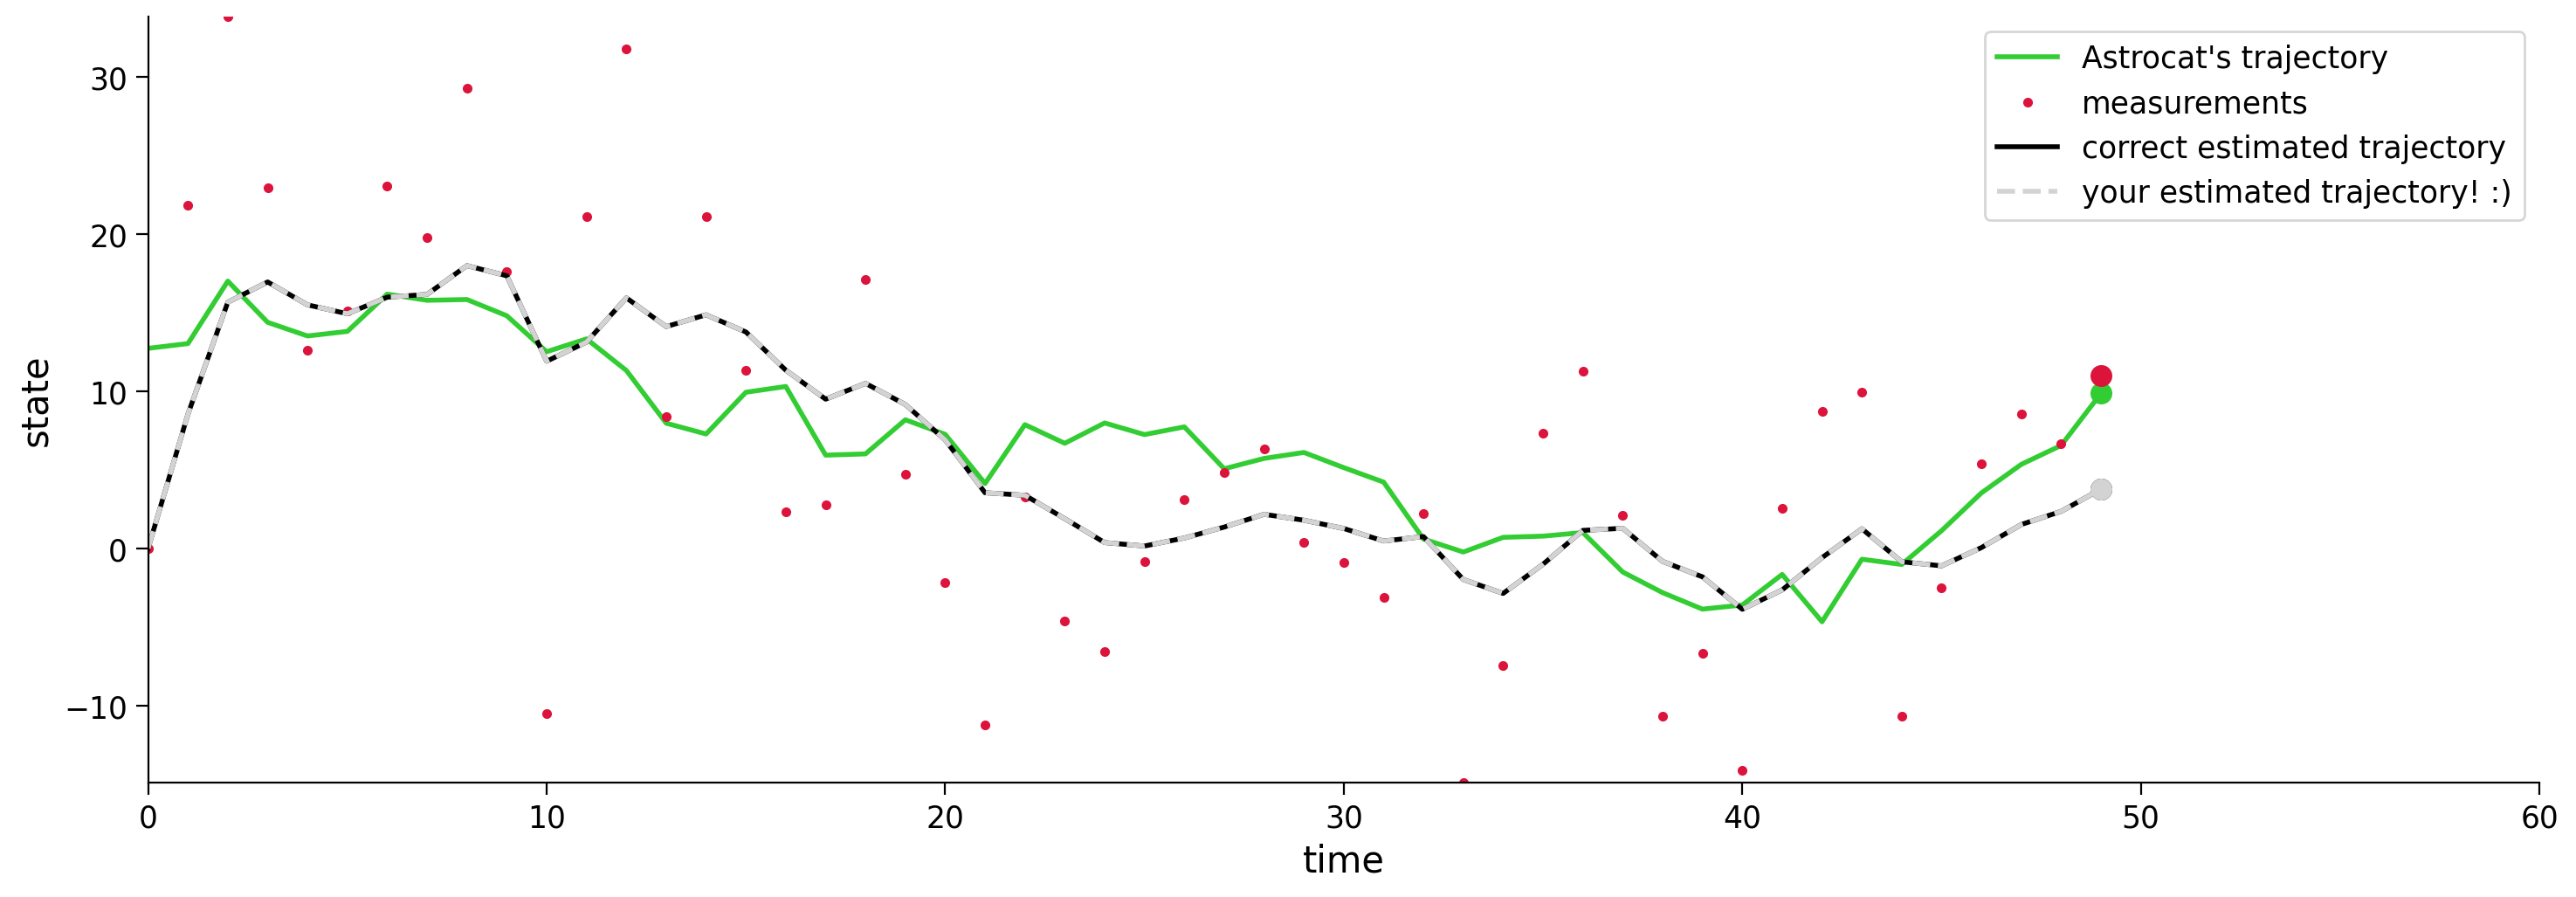

In [12]:

# Set random seed
np.random.seed(0)

# Set parameters
T = 50                  # Time duration
tau = 25                # dynamics time constant
process_noise = 2       # process noise in Astrocat's propulsion unit (standard deviation)
measurement_noise = 9   # measurement noise in Astrocat's collar (standard deviation)

# Auxiliary variables
process_noise_cov = process_noise**2          # process noise in Astrocat's propulsion unit (variance)
measurement_noise_cov = measurement_noise**2  # measurement noise in Astrocat's collar (variance)

# Initialize arrays
t = np.arange(0, T, 1)   # timeline
s = np.zeros(T)          # states
D = np.exp(-1/tau)       # dynamics multiplier (matrix if s is vector)

m = np.zeros(T)          # measurement
s_ = np.zeros(T)         # estimate (posterior mean)
cov_ = np.zeros(T)       # uncertainty (posterior covariance)

# Initial guess of the posterior at time 0
initial_guess = gaussian(0, process_noise_cov/(1-D**2))    # In this case, the initial guess (posterior distribution
                                                           # at time 0) is the equilibrium distribution, but feel free to
                                                           # experiment with other gaussians
posterior = initial_guess

# Sample initial conditions
s[0] = posterior.mean + np.sqrt(posterior.cov) * np.random.randn()   # Sample initial condition from posterior distribution at time 0
s_[0] = posterior.mean
cov_[0] = posterior.cov

# Loop over steps
for i in range(1, T):

  # Sample true states and corresponding measurements
  s[i] = D * s[i-1] + np.random.normal(0, process_noise)    # variable `s` records the true position of Astrocat
  m[i] = s[i] + np.random.normal(0, measurement_noise)      # variable `m` records the measurements of Astrocat's collar

  # Step 1. Shift yesterday's posterior to match the deterministic change of the system's dynamics,
  #         and broad it to account for the random change (i.e., add mean and variance of process noise).
  todays_prior = gaussian(D * posterior.mean, D**2 * posterior.cov + process_noise_cov)

  # Step 2. Now that yesterday's posterior has become today's prior, integrate new evidence
  #         (i.e., multiply gaussians from today's prior and likelihood)
  likelihood = gaussian(m[i], measurement_noise_cov)

  # Step 2a:  To find the posterior variance, add informations (inverse variances) of prior and likelihood
  info_prior = 1/todays_prior.cov
  info_likelihood = 1/likelihood.cov
  info_posterior = info_prior + info_likelihood

  # Step 2b: To find the posterior mean, calculate a weighted average of means from prior and likelihood;
  #          the weights are just the fraction of information that each gaussian provides!
  prior_weight = info_prior / info_posterior
  likelihood_weight = info_likelihood / info_posterior
  posterior_mean = prior_weight * todays_prior.mean  +  likelihood_weight * likelihood.mean

  # Don't forget to convert back posterior information to posterior variance!
  posterior_cov = 1/info_posterior
  posterior = gaussian(posterior_mean, posterior_cov)

  s_[i] = posterior.mean
  cov_[i] = posterior.cov

# Visualize
paintMyFilter(D, initial_guess, process_noise_cov, measurement_noise_cov, s, m, s_, cov_)

## Sección 2.2: Precisión de estimación

### Demo Interactivo 2.2: Comparar estados, estimaciones y mediciones



¿Qué tan bien coinciden las estimaciones $\hat{s}$ con los valores reales $s$? ¿Cómo se compara la distribución de errores $\hat{s}_t - s_t$ con la varianza posterior? ¿Por qué? Pruebe diferentes parámetros del modelo oculto de Markov y observe cómo cambian las propiedades.

¿Cómo se comparan las _mediciones_ $m$ con los estados reales?

Ejecutar celular para habilitar la demo

In [13]:
# @markdown Ejecutar celular para habilitar la demo
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(tau=widgets.FloatSlider(tau_max/2, description='tau',
                                          min=tau_min, max=tau_max),
                  process_noise=widgets.FloatSlider(2,
                                                    description="process noise",
                                                    min=process_noise_min,
                                                    max=process_noise_max),
                  measurement_noise=widgets.FloatSlider(3,
                                                        description="observation noise",
                                                        min=measurement_noise_min,
                                                        max=measurement_noise_max),
                  flag_m = widgets.Checkbox(value=False,
                                            description='measurements',
                                            disabled=False, indent=False))

def stochastic_system(tau, process_noise, measurement_noise, flag_m):
  T = T_max
  t = np.arange(0, T_max, 1)  # timeline
  s = np.zeros(T_max)  # states
  D = np.exp(-1/tau)  # dynamics multiplier (matrix if s is vector)

  process_noise_cov = process_noise**2  # process noise in Astrocat's propulsion unit (variance)
  measurement_noise_cov = measurement_noise**2  # measurement noise in Astrocat's collar (variance)

  prior_mean = 0
  prior_cov = process_noise_cov/(1-D**2)

  s[0] = np.sqrt(prior_cov) * np.random.randn()  # Sample initial condition from equilibrium distribution

  m = np.zeros(T_max)  # measurement
  s_ = np.zeros(T_max)  # estimate (posterior mean)
  cov_ = np.zeros(T_max)  # uncertainty (posterior covariance)

  s_[0] = prior_mean
  cov_[0] = prior_cov
  posterior = gaussian(prior_mean, prior_cov)

  for i in range(1, T):
    s[i] = D * s[i-1] + process_noise * np.random.randn()
    m[i] = s[i] + measurement_noise * np.random.randn()

    prior, likelihood, posterior = filter(D, process_noise_cov,
                                          measurement_noise_cov,
                                          posterior, m[i])

    s_[i] =  posterior.mean
    cov_[i] = posterior.cov

  fig = plt.figure(figsize=[10, 5])
  ax = plt.subplot(1, 2, 1)
  ax.set_xlabel('s')
  ax.set_ylabel('$\mu$')

  sbounds = 1.1*max(max(np.abs(s)), max(np.abs(s_)), max(np.abs(m)))
  ax.plot([-sbounds, sbounds], [-sbounds, sbounds], 'k')  # plot line of equality
  ax.errorbar(s, s_, yerr=2*np.sqrt(cov_[-1]), marker='.',
              mfc='black', mec='black', linestyle='none', color='gray')

  axhist = plt.subplot(1, 2, 2)
  axhist.set_xlabel('error $s-\hat{s}$')
  axhist.set_ylabel('probability')
  axhist.hist(s-s_, density=True, bins=25, alpha=.5,
              label='histogram of estimate errors', color='yellow')

  if flag_m:
    ax.plot(s, m, marker='.', linestyle='none', color='red')
    axhist.hist(s - m, density=True, bins=25, alpha=.5,
                label='histogram of measurement errors', color='orange')

  domain = np.arange(-sbounds, sbounds, 0.1)
  pdf_g = norm.pdf(domain, 0, np.sqrt(cov_[-1]))
  axhist.fill_between(domain, pdf_g, color='black',
                      alpha=0.5, label='posterior shifted to mean')
  axhist.legend()

  plt.show()

interactive(children=(FloatSlider(value=25.0, description='tau', max=50.0, min=1.0), FloatSlider(value=2.0, de…

## Sección 2.3: Buscando a Astrogato

### Demo Interactivo 2.3: ¿Cuánto tiempo se tarda en encontrar a Astrogato?



Aquí trazamos la varianza posterior en función del tiempo. Antes de que el control de la misión obtenga mediciones, su única información sobre la ubicación de Astrogato es la anterior. Después de algunas mediciones, se concentraron en Astrogato.
* ¿Cómo se reduce la varianza con el tiempo?
* La velocidad depende de la dinámica del proceso, pero ¿depende también de la relación señal-ruido (SNR)? (Aquí medimos la SNR en decibeles, una escala logarítmica donde 1 dB significa 0,1 unidad logarítmica).

La curva roja muestra qué tan rápido la varianza latente se equilibra exponencialmente a partir de una condición inicial, con una constante de tiempo de $\sim 1/(1-D^2)$. (**Nota:** Ajustamos la curva desplazándola y escalando para que se alinee visualmente con la varianza del equilibrio posterior. Esto facilita la comparación de escalas de tiempo). ¿El proceso latente converge más rápido o más lento que el posterior? ¿Puedes explicar esto basándose en cómo el filtro de Kalman integra la evidencia?

Ejecute esta celda para habilitar la demo

In [14]:
# @markdown Ejecute esta celda para habilitar la demo

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(T=widgets.IntSlider(tau_max, description="max time",
                                      min=2, max=T_max-1),
                  tau=widgets.FloatSlider(tau_max/2,
                                          description='time constant',
                                          min=tau_min, max=tau_max),
                  SNRdB=widgets.FloatSlider(-20.,
                                            description="SNR (decibels)",
                                            min=-40., max=10.))


def stochastic_system(T, tau, SNRdB):
  t = np.arange(0, T, 1)  # timeline
  s = np.zeros(T)  # states
  D = np.exp(-1/tau)  # dynamics matrix (scalar here)
  prior_mean = 0
  process_noise = 1
  SNR = 10**(.1*SNRdB)
  measurement_noise = process_noise / SNR
  prior_cov = process_noise/(1-D**2)

  s[0] = np.sqrt(prior_cov) * unit_process_noise[0]   # Sample initial condition from equilibrium distribution

  m = np.zeros(T)  # measurements
  s_ = np.zeros(T)  # estimates (posterior mean)
  cov_ = np.zeros(T)  # uncertainty (posterior covariance)
  pcov = np.zeros(T)  # process covariance

  s_[0] = prior_mean
  cov_[0] = prior_cov
  posterior = gaussian(prior_mean, prior_cov)

  for i in range(1, T):
    s[i] = D * s[i-1] + np.sqrt(process_noise) * unit_process_noise[i-1]
    m[i] = s[i] + np.sqrt(measurement_noise) * unit_measurement_noise[i]

    prior, likelihood, posterior = filter(D, process_noise,
                                          measurement_noise, posterior, m[i])

    s_[i] =  posterior.mean
    cov_[i] = posterior.cov
    pcov[i] = D**2 * pcov[i-1] + process_noise

  equilibrium_posterior_var = process_noise * (D**2 - 1 - SNR + np.sqrt((D**2 - 1 - SNR)**2 + 4 * D**2 * SNR)) / (2 * D**2 * SNR)

  equilibrium_process_var = process_noise / (1-D**2)

  scale = (max(cov_) - equilibrium_posterior_var) / equilibrium_process_var
  pcov = pcov * scale   # scale for better visual comparison of temporal structure

  fig, ax = plt.subplots()
  ax.set_xlabel('time')
  ax.set_xlim([0, T])

  ax.fill_between(t, 0, cov_, color='black', alpha=0.3)
  ax.plot(t, cov_, color='black', label='posterior variance')
  ax.set_ylabel('posterior variance')
  ax.set_ylim([0, max(cov_)])

  ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
  ax2.fill_between(t, min(pcov), pcov, color='red', alpha=0.3)
  ax2.plot(t, pcov, color='red', label='hidden process variance')
  ax2.set_ylabel('hidden process variance (scaled)', color='red',
                 rotation=-90, labelpad=20)

  ax2.tick_params(axis='y', labelcolor='red')
  # ax2.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
  ax2.set_yticks([0, equilibrium_process_var - equilibrium_posterior_var])
  ax2.set_yticklabels(['0', 'equilibrium\nprocess var'])
  ax2.set_ylim([max(cov_), 0])

  fig.tight_layout()  # otherwise the right y-label is slightly clipped

  plt.show()

interactive(children=(IntSlider(value=50, description='max time', max=199, min=2), FloatSlider(value=25.0, des…